<h1 align="center"> Emails Spam Detector</h1>

<h2>Introduction</h2>

Usually, classification problems can be split into 2 categories: <b>binary classification (2 only possible label</b>) and <b>multi-classification (more than 2 label class)</b>. In this notebook, my goal is to <b>explore and understand the process of classifying email as spam or legitimate.</b> This is a classic binary classification problem. There are real-world problem can be solved by this method such as by detecting unsocilicited and unwanted emails, we can't prevent harmful and spam message from anonymous users (such as in gmail). Therefore, we can protect the privacy and improving user experience.

# Preprocess the data

In [1]:
# Importing Libraries

#Data Preprocessing
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords    #‘the’, ‘a’,....
from nltk.tokenize import word_tokenize
from nltk import ngrams
import re


#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud


#Feature Engineering
import string
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder


#Machine Learning Model
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense,LSTM,Embedding,Dropout,Activation,Bidirectional
import tensorflow as tf


#Evaluation Metric
from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Badr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Badr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Load the dataset :
df = pd.read_csv("Spam_in_emails.csv")
df.head()

,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday es...
3,1,university degree obtain a prosperous future m...
4,0,thanks for all your answers guys i know i shou...


In this dataset:

 * '1' indicates that the email is classified as spam.
 * '0' denotes that the email is legitimate (ham).

In [3]:
# Checking for nulls :
df.isnull().sum()

label    0
text     0
dtype: int64

In [4]:
# Dimensions
df.shape

(83448, 2)

In [5]:
df["text"] = df["text"].str.lower()

#### Remove Numbers and Special Character

Often, characters, symbols, and numbers usually don't contribute to differentiating spam from legitimate emails.

In [6]:
def remove_special_chars(word) :
    return word.translate(str.maketrans("", "", string.punctuation))

In [7]:
df["text"] = df["text"].apply(remove_special_chars)

#### Remove English stop-words

Stopwords e like ‘the’, ‘a’,.... can be removed from the text because they don’t provide valuable information. **Tokenization** is the process of splitting text into smaller chunks, called tokens.

In [8]:
# Define the stop-words in English
ENGLISH_STOP_WORDS = set(stopwords.words("English"))

def remove_stop_words(words) :
    return [word for word in words if word not in ENGLISH_STOP_WORDS]

# Tokenize the text
df["text"] = df["text"].apply(word_tokenize)

# Remove stop words:
df["text"] = df["text"].apply(remove_stop_words)

In [9]:
# Rejoin words for EDA
df['text'] = df['text'].apply(' '.join)
df["text"]

0        ounce feather bowl hummingbird opec moment ala...
1        wulvob get medircations online qnb ikud viagra...
2        computer connection cnn com wednesday escapenu...
3        university degree obtain prosperous future mon...
4        thanks answers guys know checked rsync manual ...
                               ...                        
83443    hi given date get last date month data form yy...
83444    order software cd download site immediately de...
83445    dear valued member canadianpharmacy provides w...
83446    subscribe change profile contact us long term ...
83447    get life viagra helped millions men good cause...
Name: text, Length: 83448, dtype: object

#### Removal of hyperlinks

Some emails contains URL which doesn't provide any valuable information.

In [10]:
def remove_hyperlink(word):
    return re.sub(r"http\S+", "", word)

df['text'] = df['text'].apply(remove_hyperlink)

# Exploratory Data Analysis

Let's check with an example of a spam text

In [11]:

for i in range(1,5) :
    print("Email #{} :".format(i))
    print(df[df["label"] == 1 ]["text"].iloc[i] +"\n")

Email #1 :
wulvob get medircations online qnb ikud viagra escapenumber escapenumber levitra escapenumber escapenumber cialis escapenumber escapenumber imitrex escapenumber escapenumber flonax escapenumber escapenumber ultram escapenumber escapenumber vioxx escapenumber escapenumber ambien escapenumber escapenumber valium escapenumber escapenumber xannax escapenumber escapenumber soma escapenumber meridia escapenumber escapenumber escapenumber escapenumber cysfrt ever stopped wonder much average man pays mediecines ap painkillers drugs improve quality life weight reducing tablets many escapenumber whats worse mediucine costs lot branded rfwur intrested http dmvrwm remunerativ net dfuaeirxygiq visit website escapenumber

Email #2 :
university degree obtain prosperous future money earning power prestige comes career position youve always dreamed diploma prestigious non accredited unversities based present knowledge professional experience qualify required tests classes books examinations

Why those emails are classified as spam?

**Email 1: Medication Offers**

   * Unsolicited Advertising: The email is promoting medications like Viagra, Levitra, Cialis, and others, which is a common theme in spam emails.
   * Random Words and Phrases: The message includes a mix of random words and pharmaceutical names, a tactic often used in spam to bypass filters.
   * Suspicious Links: The mention of a website to visit for purchasing medications is a red flag. Legitimate pharmaceutical companies typically don't market their products in such a manner.
* Irregular Formatting: Use of random characters and inconsistent spacing (e.g., "wulvob", "qnb ikud") is common in spam to evade detection algorithms.
* Lack of Personalization: The email is generic and does not address any recipient directly, implying it was sent to a mass audience.

**Email 2: Offering University Degrees**

* False Promises: Offering a university degree with no need for tests, classes, books, or exams is unrealistic and typical of educational scam emails.
* Anonymity: The assurance of confidentiality and the lack of any legitimate university names.
* 24/7 Availability: Claiming availability "24 hours a day, 7 days a week" is not typical for legitimate educational institutions.
* Lack of Specific Details: The email is vague about the nature of the degrees and the process, which is characteristic of spam.

Therefore, the main characteristics of spam emails are often:

* Unsolicited Advertising: Spam emails often promote products or services without the recipient's prior consent.

* Random and Irregular Text: They frequently contain a mix of random words, phrases, and characters to evade spam filters.

* Deceptive Offers: Spam messages commonly include unrealistic or too-good-to-be-true offers, like quick degrees or cheap medications.

* Lack of Personalization: These emails are typically generic, lacking direct addressing or personalization, indicating mass distribution.

* Suspicious Links or Instructions: They often contain suspicious links or unclear instructions, potentially leading to phishing sites or scams.

* Incoherent Content: The content in spam emails is often disjointed and lacks a clear, coherent message or purpose.

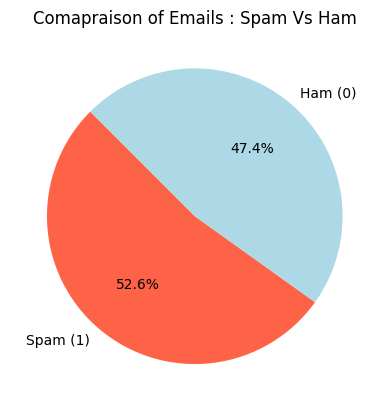

In [12]:
# Count the number of spam and legitimate emails
email_counts = df["label"].value_counts()

# Plotting
plt.pie(x = email_counts, labels= ["Spam (1)", "Ham (0)"], autopct="%1.1f%%",
       startangle= 135, colors=['tomato', 'lightblue'])
plt.title("Comapraison of Emails : Spam Vs Ham")
plt.show()

The chart shows that **52.6% of the emails are classified as spam**, while **47.4% are classified as legitimate (ham)**. This nearly even split indicates that the dataset is fairly balanced between the two classes, which is good for training a machine learning model because it reduces the risk of the model being biased towards one class.

#### Word Frequency Analysis

Create a bar chart of the most frequent words in both spam and legitimate emails.

In [13]:
# Separate the spam and legitimate emails
spam_emails = df[df["label"] == 1]["text"]
ham_emails = df[df["label"] == 0]["text"]

# Count word frequencies for spam
spam_words = Counter()
spam_emails.apply(lambda x: spam_words.update(x.split()))

# Count word frequencies for ham
ham_words = Counter()
ham_emails.apply(lambda x: ham_words.update(x.split()))

# Retrieve the 10 most common words
spam_common = spam_words.most_common(10)
ham_common = ham_words.most_common(10)

# Convert to DataFrame
spam_common_df = pd.DataFrame(spam_common, columns=["Word", "Frequency"])
ham_common_df = pd.DataFrame(ham_common, columns=["Word", "Frequency"])

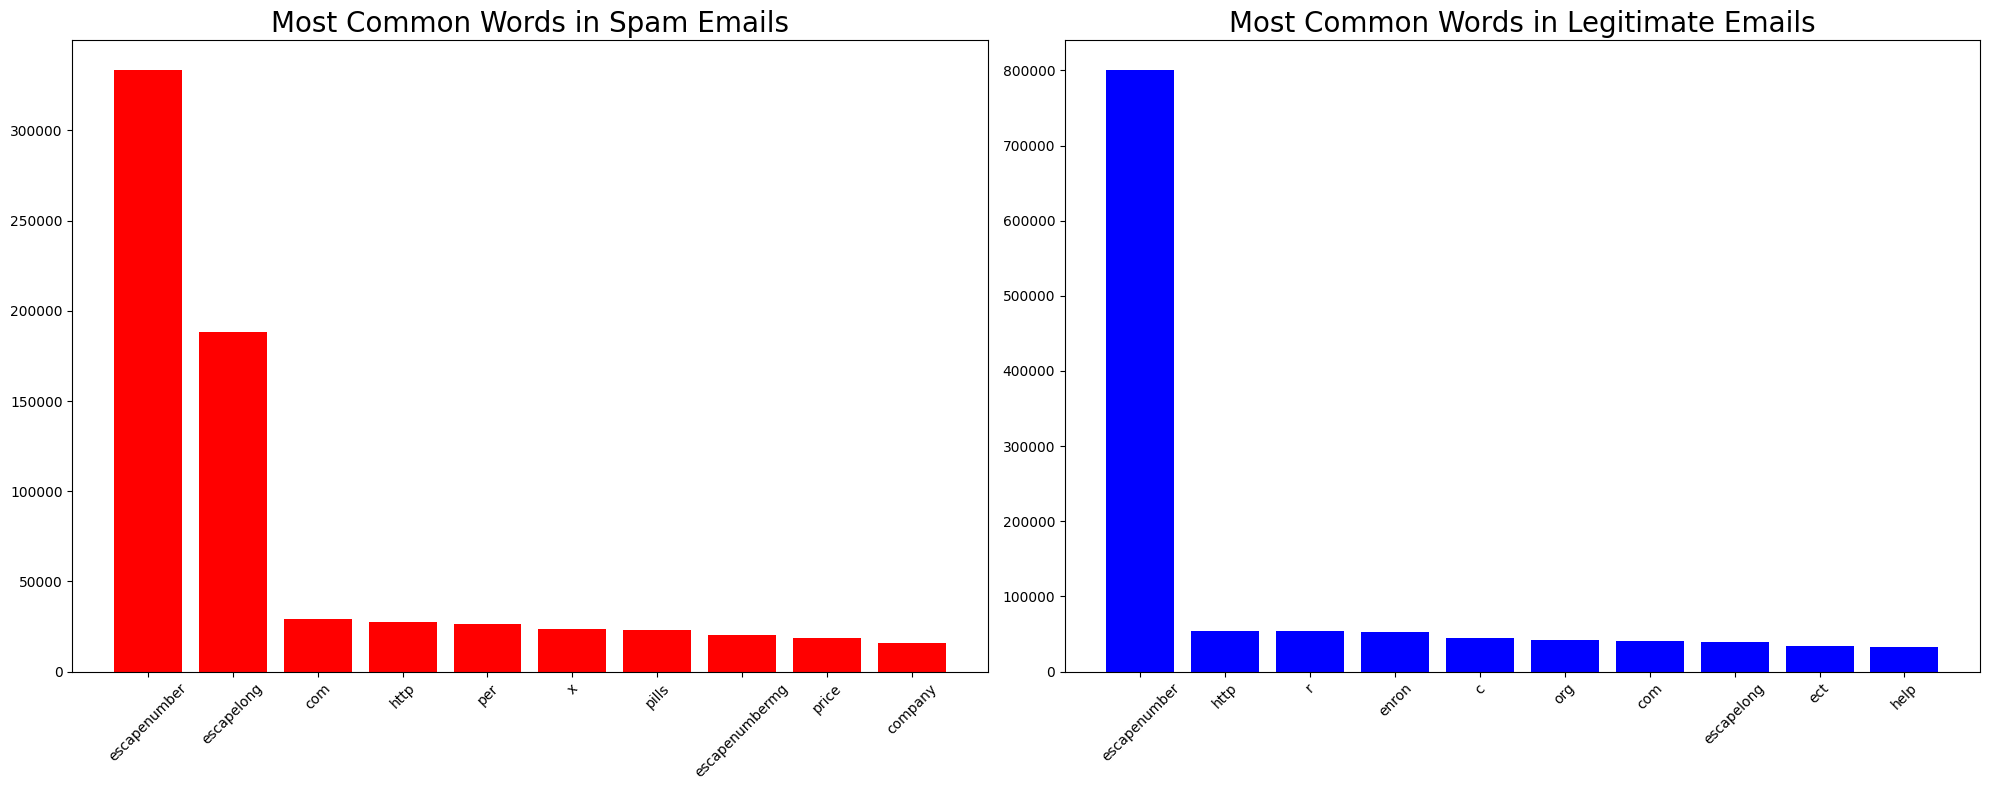

In [14]:
# Plotting the most common words in spam emails
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.bar(x = spam_common_df["Word"], height = spam_common_df["Frequency"], color="red")
plt.title('Most Common Words in Spam Emails', fontsize = 20)
plt.xticks(rotation=45)

plt.subplot(1,2,2)
plt.bar(x = ham_common_df["Word"], height = ham_common_df["Frequency"], color = "blue")
plt.title("Most Common Words in Legitimate Emails", fontsize = 20)
plt.xticks(rotation = 45)

plt.tight_layout()
plt.show()

#### Word Cloud

Word clouds for spam and ham emails help visualize the most common words in each category.

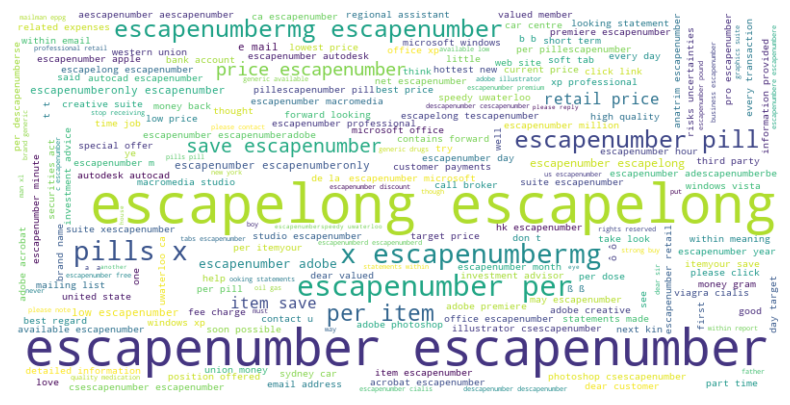

In [15]:
# Generate a word cloud image for spam words
spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(spam_emails))

# Display the image
plt.figure(figsize=(10, 5))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### N-gram Analysis

The purpose of n-gram analysis is to explore the most common sequences of two or three words in spam and legitimate emails. This could help in understanding common phrases used in both types of emails.

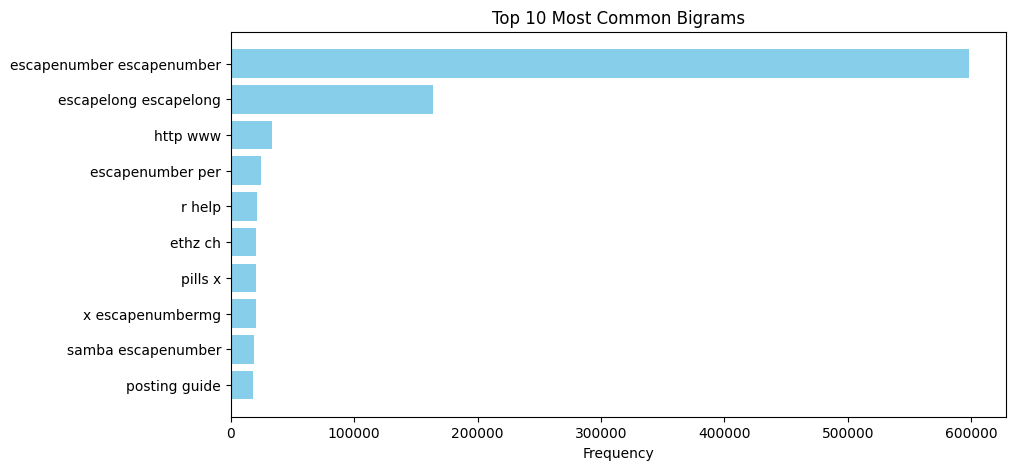

In [16]:
# Extract n-grams from text
def generate_ngrams(text, n=2): # n=2 bigrams
    # Split the text into words
    words = text.split()
    # Ensure that there is no enough words
    if len(words) >= n:
        return [' '.join(grams) for grams in ngrams(words, n)]
    else:
        return []

# Convert bigrams
df['bigrams'] = df['text'].apply(lambda x: generate_ngrams(x, n=2))

# count the frequencies
bigram_counts = Counter([bigram for sublist in df['bigrams'] for bigram in sublist])

# Get the most common bigrams (top10)
most_common_bigrams = bigram_counts.most_common(10)

# Convert to DataFrame for visualization
bigrams_df = pd.DataFrame(most_common_bigrams, columns=['Bigram', 'Frequency'])

# Plot the most common bigrams
plt.figure(figsize=(10, 5))
plt.barh(y = bigrams_df['Bigram'], height= bigrams_df['Frequency'], color='skyblue')
plt.xlabel('Frequency')
plt.title('Top 10 Most Common Bigrams')
plt.gca().invert_yaxis()  # Display the highest count at the top
plt.show()

# Feature Engineering

## Splitting data into training and test set

In [44]:
# Split the data into features and target
X = df["text"]
y = df["label"]

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify= y, test_size=.3, random_state= 1)

#### Tokenization 

Tokenization is the process of splitting text into smaller chunks, called tokens. Each token is an input to the machine learning algorithm as a feature.

In Python, `keras.preprocessing.text.Tokenizer` is a utility function that help tokenizes a text into tokens while keeping only the words that frequently occur. After tokenizing the text, we often end up with a massive dictionary of words which won’t all be necessary. One solution for this problem is setting `max_features` to select the top frequent words that we want to consider.

In [45]:
max_features = 5000
tokenizer = Tokenizer(num_words= max_features)
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

#### Padding

Padding is the step of making all tokens for all emails to equal size. Since we send input in batches of data points, information might be lost when inputs are of different sizes. So, making them the same size help eases batch updates.

In [46]:
#Average Length
average_length = df["text"].apply(len).mean()
print("The average length is " + str(average_length))

The average length is 1305.4409692263446


In [50]:
max_length = int(average_length)

# Padding sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding="post")
X_test_padded = pad_sequences(X_test_seq, maxlen= max_length, padding= "post")

#### Label the encoding target variable

The model expect the target variable as a number instead of string. Therefore, we can use a Label encoder to convert our target variable.

In [51]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [52]:
type(y_test)

pandas.core.series.Series

# Model Selection


To simplify with an example, let say we analyze a movie, which consists of a sequence of scenes. When we watch a scene, we can't understand the movie at whole, but rather in connection with previous scenes. Text works in a similar way, a machine learning model has to understand the text by utilizing already-learned text (like a human neural network).

#### Recurrent neural network (RNN)
For those reasons, **Recurrent neural network (RNN)** is a perfect fit. It has a repeating module that takes input from the previous stage and gives its output as input to the next stage. One limit of RNNs is that we can only retain information from the most recent stage. To learn long-term dependencies, our network needs memorization power. Therfore, **Long Short Term Memory Networks (LSTMs)** works perfectly to solve this problem.

#### Long Short Term Memory Networks (LSTMs)
In short, LSTMs are a special case of RNNs, which have similar chain-like structure as RNNs, but with a different repeating module structure. In this model, we will use **Bi-directional LSTM**. In a Bi-directional LSTM, the input sequence is fed in two ways: one from past to future and one from future to past. This can provide additional context to the network and result in a fuller understanding of the data.

In [54]:
embedding_vector_length = 32
model = tf.keras.Sequential()
model.add(Embedding(input_dim = max_features,
                    output_dim = embedding_vector_length,
                    input_length = max_length))

# Using Bi-directional LSTM
model.add(Bidirectional(tf.keras.layers.LSTM(64)))

# Optimizer: Use Adam from tf.keras.optimizers
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)  # Adjust the learning rate as needed

# optimizer we will use is the AdamOptimizer, the activation function that is used in this scenario is "Relu" 
model.add(Dense(16, activation='relu'))

model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1305, 32)          160000    
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               49664     
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 16)                2064      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 211745 (827.13 KB)
Trainable params: 211745 (827.13 KB)
Non-trainable params: 0 (0.00 Byte)
______________

#### What Is a Batch?
The batch size is a hyperparameter that defines the number of samples to work through before updating the internal model parameters.


#### What Is an Epoch?
The number of epochs is a hyperparameter that defines the number times that the learning algorithm will work through the entire training dataset.

# Train the model


In [60]:
history = model.fit(X_train_padded, y_train_encoded,
                   batch_size= 512,
                   epochs= 20,
                   validation_data= (X_test_padded, y_test_encoded))

Epoch 1/20
115/115 [==============================] - 5447s 48s/step - loss: 0.1006 - accuracy: 0.9691 - val_loss: 0.0642 - val_accuracy: 0.9783
Epoch 2/20
 79/115 [===================>..........] - ETA: 45:24 - loss: 0.0535 - accuracy: 0.9841

KeyboardInterrupt: 

# Performance Metrics

## Prediction and Evaluation

In [56]:
y_pred = model.predict(X_test_padded)
y_predict = [1 if o > 0.5 else 0 for o in y_pred]

783/783 [==============================] - 207s 262ms/step


## Precision, Recall, F1 Score

In [57]:
cf_matrix =confusion_matrix(y_test_encoded,y_predict)
tn, fp, fn, tp = confusion_matrix(y_test_encoded,y_predict).ravel()
print("Precision: {:.2f}%".format(100 * precision_score(y_test_encoded, y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test_encoded, y_predict)))
print("F1 Score: {:.2f}%".format(100 * f1_score(y_test_encoded,y_predict)))

Precision: 88.90%
Recall: 98.91%
F1 Score: 93.64%


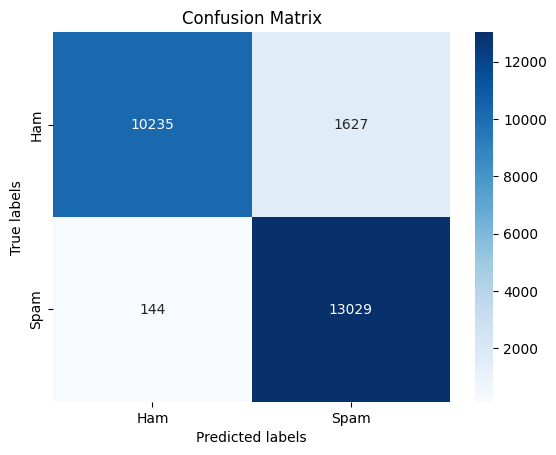

In [59]:
ax= plt.subplot()

#annot=True to annotate cells
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt='');

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Ham', 'Spam']);
ax.yaxis.set_ticklabels(['Ham', 'Spam']);

This model is good model such as it has an F1 score of 93.64%. However, these result are only fit to this specific training dataset. When using this model to real-world data, we need to actively monitor the model's performance over time. We can also improve the model by responding to results and adding features to improve the result.

# Summary

In this notebook, I created a spam detection model by converting text data into tokens, adding feature, creating a Bi-LSTM model, and fitting the model with these vectors. Similarly, these concepts and techniques learned can be applied to other real-world example such as building chatbots, text summarization, language translation models, or detect LLM.